# CNN Cancer Detection Kaggle Mini-Project

##  Brief Description of The Problem and Data 

This project is part of a Kaggle competition aimed at automatically detecting metastatic cancer in small image patches extracted from larger digital pathology scans. The goal is to develop a binary classifier that can predict whether a given image patch contains cancerous tissue.

## Data Overview

Dataset: The dataset consists of image patches of size 96x96 pixels. 
Training Set: Contains labeled images to train the model. 
Test Set: Contains unlabeled images for which predictions are needed. 
Class Distribution: The class labels indicate the presence (1) or absence (0) of cancer.


In [30]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import setuptools.dist
from PIL import Image
import tensorflow as tf
# Because I'm using jupyter notebook in vs code, I had to add "python" after tensorflow to get these libraries working
# https://stackoverflow.com/questions/71316443/google-colab-error-import-tensorflow-keras-models-could-not-be-resolvedrepor
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, InputLayer
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.engine import data_adapter
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator
from tensorflow.python.keras.regularizers import l2
from torch.utils.data import Dataset

In [3]:
train_images_path = ('./data/train/')
test_images_path = ('./data/test/')
train_labels_data = pd.read_csv('./data/train_labels.csv')
print(train_labels_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


In [4]:
print(train_labels_data.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## EDA(Exploratory Data Analysis)



In [5]:
train_labels_data.isnull().sum()

id       0
label    0
dtype: int64

As per the data description from Kaggle, this dataset was already cleaned therefore no duplicates and null.
Let's start with data visualization.

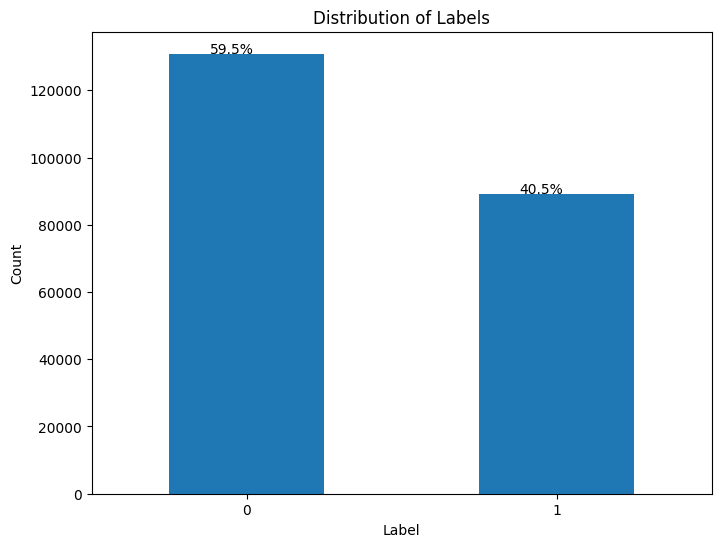

In [6]:
# Visualize class distribution and check for class imbalance

label_counts = train_labels_data['label'].value_counts()

plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

total = len(train_labels_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + total * 0.001
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

There is about 20% more non-cancer label than cancer label as per the chart above.

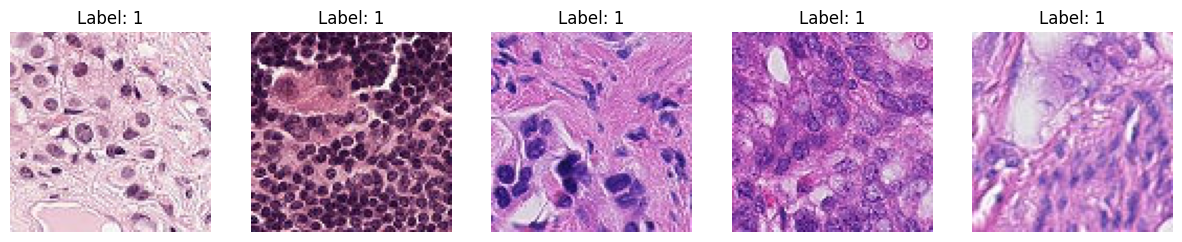

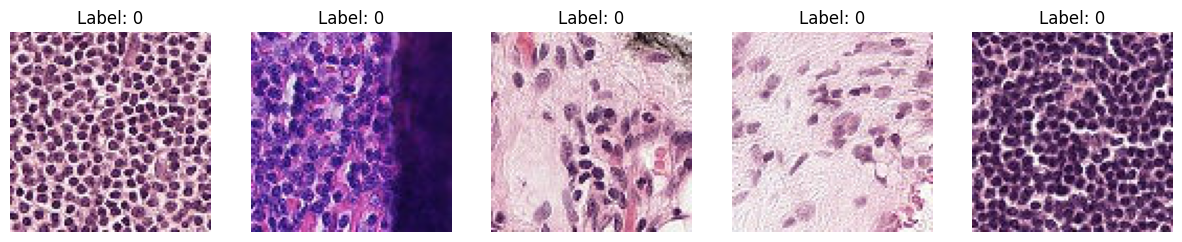

In [7]:
sample_cancer_ids = train_labels_data[train_labels_data['label'] == 1]['id'].sample(n=5).values
sample_normal_ids = train_labels_data[train_labels_data['label'] == 0]['id'].sample(n=5).values

cancer_images = []
for id in sample_cancer_ids:
    image_path = os.path.join(train_images_path, id + '.tif')  
    cancer_images.append(Image.open(image_path))
    
normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_images_path, id + '.tif') 
    normal_images.append(Image.open(image_path))
    
plt.figure(figsize=(15, 3))
for i, image in enumerate(cancer_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Label: 1')
    plt.axis('off')
plt.show()

plt.figure(figsize=(15, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Label: 0')
    plt.axis('off')
plt.show()

From the photos, without any medical background, I cannot tell the difference between cancer and normal cells.
Now let's preprocess those images to prepare for model architecture work. The ImageDataGenerator resizes and normalizes images, and splits the training data for validation. Labels are adjusted to ensure compatibility with the generator functions.

### Image Preprocessing

In [8]:
# Rescale pixel values, split for validation, and prepare ImageDataGenerators
batch_size = 64
target_size = (60, 60)

train_datagen = image_data_generator(
    rescale=1./255,  # Normalize image pixel values
    validation_split=0.25  # Reserve a portion for validation
)

# Update 'id' column to match file names and convert 'label' to string for generator
train_labels_data['id'] = train_labels_data['id'].apply(lambda x: x + '.tif')
train_labels_data['label'] = train_labels_data['label'].astype(str)

# Initialize generators for train and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_data,
    directory=train_images_path,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_data,
    directory=train_images_path,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


## Model Architecture

The chosen model is a Convolutional Neural Network(CNN) due to its effectiveness in image classification tasks.

Two models with different architecture will be compared. 
Here are the differences:

1. Number of Filters
- Basic Model:
    - First Conv2D layer: 16 filters
    - Second Conv2D layer: 32 filters
    - Total filters = 16 + 32 = 48
- Enhanced Model:
    - First Conv2D layer: 32 filters
    - Second Conv2D layer: 64 filters
    - Third Conv2D layer: 128 filters
    - Total filters = 32 + 64 + 128 = 224

**Effect**: The enhanced model has more filters per convolution layer, allowing it to learn more features at each level. This increases its representational capacity but also increases computation and risk of overfitting.

2. Number of Convolution Layers
- Basic Model:
    - 2 convolution layers.
- Enhanced Model:
    - 3 convolution layers.

**Effect**: The enhanced model goes deeper, enabling it to learn more hierarchical and complex features. Additional layers extract finer details, which can improve performance for more complex datasets.

3. Dense Layer
- Basic Model:
    - One dense layer with 128 neurons.
- Enhanced Model:
    - One dense layer with 256 neurons.
**Effect**: The enhanced model has a larger fully connected layer, which allows it to process more high-level features after the convolutional layers. This increases model capacity but can also make the model more prone to overfitting if the dataset is small.

4. Regularization (Dropout)
- Basic Model:
    - No dropout.
- Enhanced Model:
    - Includes a Dropout layer with a rate of 0.5 before the final output layer.
**Effect**: Dropout reduces overfitting by randomly deactivating 50% of the neurons during training. This makes the enhanced model more robust, especially for datasets prone to overfitting.

5. Complexity and Parameter Count
The enhanced model has significantly more parameters due to:
- More filters per layer.
- Additional convolutional layer.
- Larger dense layer.

For example:

Basic Model: Fewer parameters → faster to train, lower memory requirements.\
Enhanced Model: More parameters → higher accuracy potential for complex tasks, but slower training and higher computational cost.

In [9]:
# Function that solves tensorflow "DistributedDatasetInterface Error"
# https://stackoverflow.com/questions/77125999/google-colab-tensorflow-distributeddatasetinterface-error
def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

In [10]:
# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Define the basic CNN architecture
basic_model = Sequential([
    Input(shape=(60, 60, 3)),
    Conv2D(16, (3, 3), activation='relu'),  # Fewer filters
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),  # Smaller dense layer
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the basic model
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
basic_model.summary()

# Train the basic model
basic_history = basic_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [13]:
# Define the enhanced CNN architecture
enhanced_model = Sequential([
    Input(shape=(60, 60, 3)),
    Conv2D(32, (3, 3), activation='relu'),  # More filters
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),  # Larger dense layer
    Dropout(0.5),  # Added regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the enhanced model
enhanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
enhanced_model.summary()

# Train the enhanced model
enhanced_history = enhanced_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 58, 58, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)             

## Results and Analysis

Let's compare the accuracy and loss for each model.

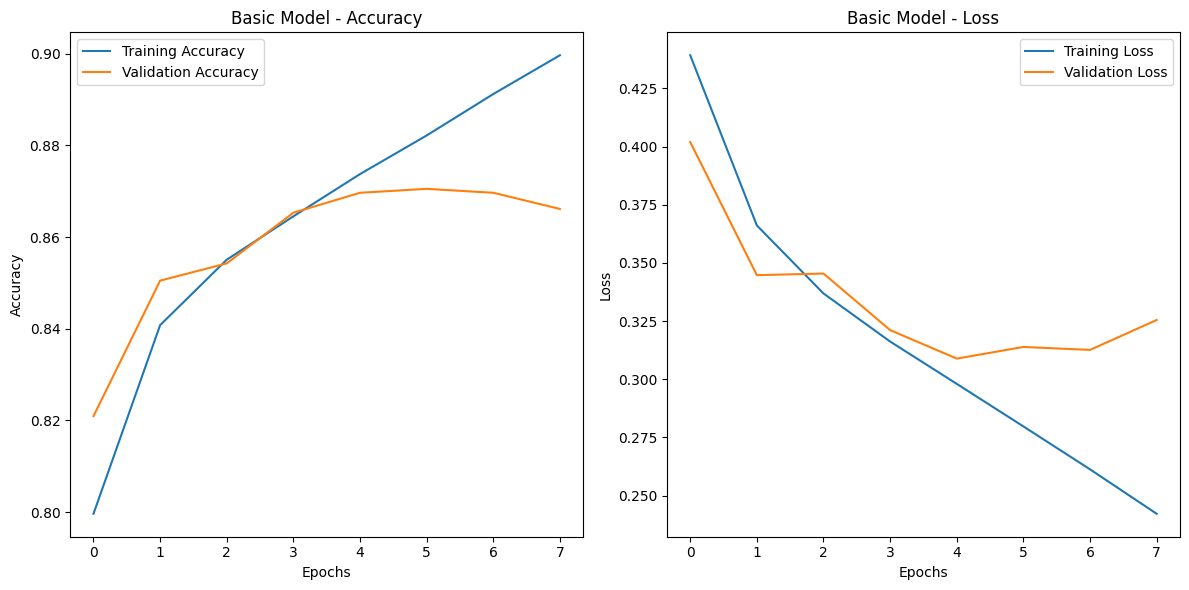

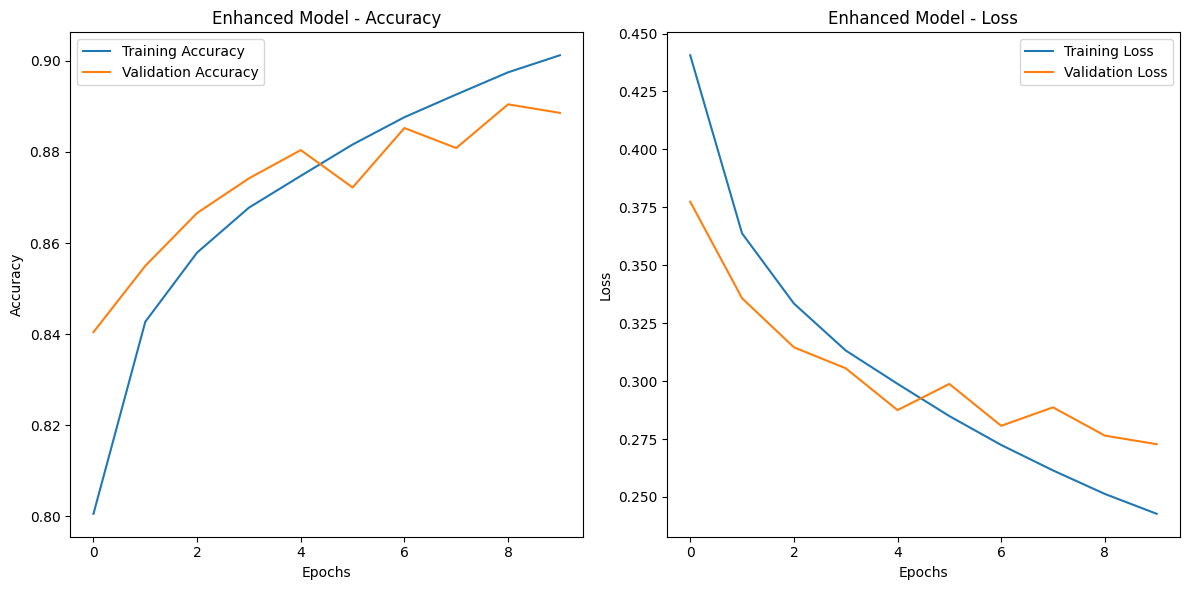

In [12]:
# Plot training and validation accuracy for Basic Model
plt.figure(figsize=(12, 6))

# Accuracy plot for Basic Model
plt.subplot(1, 2, 1)  # Subplot 1 (1 row, 2 columns, 1st plot)
plt.plot(basic_history.history['accuracy'], label='Training Accuracy')
plt.plot(basic_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Basic Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot for Basic Model
plt.subplot(1, 2, 2)  # Subplot 2 (1 row, 2 columns, 2nd plot)
plt.plot(basic_history.history['loss'], label='Training Loss')
plt.plot(basic_history.history['val_loss'], label='Validation Loss')
plt.title('Basic Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust spacing between plots
plt.show()

# Plot training and validation accuracy for Enhanced Model
plt.figure(figsize=(12, 6))

# Accuracy plot for Enhanced Model
plt.subplot(1, 2, 1)  # Subplot 1 (1 row, 2 columns, 1st plot)
plt.plot(enhanced_history.history['accuracy'], label='Training Accuracy')
plt.plot(enhanced_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Enhanced Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot for Enhanced Model
plt.subplot(1, 2, 2)  # Subplot 2 (1 row, 2 columns, 2nd plot)
plt.plot(enhanced_history.history['loss'], label='Training Loss')
plt.plot(enhanced_history.history['val_loss'], label='Validation Loss')
plt.title('Enhanced Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust spacing between plots
plt.show()




Here's an analysis of the results for both the Basic Model and Enhanced Model, based on the provided training and validation metrics:

### Basic Model Analysis
1.Training Accuracy:
- Started at 78.26% in the first epoch and improved to 88.45% by the eighth epoch.
- Indicates steady improvement, showing that the model is learning effectively during training.

2.Validation Accuracy:
- Started at 80.15% and improved to 86.06% by the eighth epoch.
- The validation accuracy shows a consistent increase, which suggests that the model is generalizing well to unseen data.

3.Training and Validation Loss:
- Training Loss decreased steadily from 0.4670 to 0.2738.
- Validation Loss initially decreased, reaching a low of 0.3312 at epoch 5 but slightly increased to 0.3320 by epoch 8.
- This minor increase in validation loss while maintaining validation accuracy could indicate slight overfitting starting from epoch 6.

4.Training Duration:
- Training each epoch took approximately 110-119 seconds.

### Enhanced Model Analysis
1.Training Accuracy:
- Started at 79.83% and improved to 90.33% by the tenth epoch.
- The improvement is greater than the basic model, especially in the later epochs, indicating that the enhancements (e.g., increased filter sizes, additional layers) improved the model's capacity to learn complex patterns.

2.Validation Accuracy:
- Started at 83.87% and improved to 88.56% by the tenth epoch.
- Higher than the basic model at all stages, showing better generalization to the validation dataset.

3.Training and Validation Loss:
- Training Loss decreased consistently from 0.4450 to 0.2344.
- Validation Loss steadily decreased from 0.3731 to 0.2825, showing effective learning without signs of overfitting.

4.Training Duration:
- Training each epoch took approximately 153-164 seconds due to the added complexity of the enhanced model.

### Comparison Between Basic and Enhanced Models

| Metric | Basic Model | Enhanced Model |
| -------- | ------- | ------- |
| Final Training Accuracy | 88.45% | 90.33% |
| Final Validation Accuracy | 86.06% | 88.56% |
| Final Training Loss | 0.2738 | 0.2344 |
| Final Validation Loss | 0.3320 | 0.2825 |
| Training Duration per Epoch | 110-119 seconds | 153-164 seconds |

### Key Observations

1.Performance:
- The Enhanced Model outperformed the Basic Model in both training and validation accuracy, and it also achieved lower losses.
- The enhancements (e.g., more filters, additional layers) allowed the model to capture more complex patterns in the data.

2.Overfitting:
- The Basic Model showed slight signs of overfitting after epoch 6, as validation loss started increasing slightly while accuracy plateaued.
- The Enhanced Model maintained consistent improvement in both validation loss and accuracy, indicating better regularization.

3.Training Time:
- The Enhanced Model took approximately 30-40% longer per epoch than the Basic Model, reflecting its higher complexity.

### Conclusion
- The Enhanced Model is more effective, with higher accuracy and lower loss for both training and validation. However, it comes at the cost of increased training time and computational requirements.
- The Basic Model is a simpler and faster option but is slightly less accurate and more prone to overfitting.
- Choose the Enhanced Model if the performance is priority and can afford the additional computational cost. For scenarios requiring faster training with decent accuracy, the Basic Model seems to be suitable choice.

In [ ]:
# Create a DataFrame for the test images
test_data = pd.DataFrame({'id': os.listdir(test_images_path)})

# Initialize the ImageDataGenerator for rescaling
datagen_test = image_data_generator(rescale=1./255)

# Create the test data generator
test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_images_path,
    x_col='id',
    y_col=None,
    target_size=(60, 60),  
    batch_size=1,         
    shuffle=False,       
    class_mode=None       
)

# Predict using the model
steps = len(test_generator)
predictions = enhanced_model.predict(test_generator, steps=steps, verbose=1)

# Process predictions
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary labels

# Extract file IDs (remove file extensions)
ids = test_data['id'].str.split('.').str[0]

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save to CSV
submission_csv_path = 'submission.csv'
submission_df.to_csv(submission_csv_path, index=False)

print(f"Submission file saved at: {submission_csv_path}")


Found 57458 validated image filenames.
57458/57458 [==============================] - 60s 1ms/step
Submission file saved at: submission.csv
